In [1]:
# import libraries
# import matplotlib.pyplot as plt
# import numpy as np
from cil.optimisation.functions import KullbackLeibler, MixedL21Norm
from cil.optimisation.operators import GradientOperator
from cil.optimisation.algorithms import PDHG
from cil.framework import ImageGeometry
from cil.utilities import noise

from cil.utilities.display import show2D
from skimage.metrics import structural_similarity as ssim
import os, sys
import tomophantom
from tomophantom import TomoP2D

In [2]:
# Load a tomophantom image 
model = 12 # select a model number from the library
N = 256 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom2D = TomoP2D.Model(model, N, path_library2D)    
ig = ImageGeometry(voxel_num_x=N, voxel_num_y=N)

In [3]:
# Fill the phantom 
data = ig.allocate()
data.fill(phantom2D)

In [4]:
# Corrupt with poisson noise
noisy_data = noise.poisson(data, seed = 10)

In [5]:
alpha = 0.3

F = alpha * MixedL21Norm()
G = KullbackLeibler(b=noisy_data)
K = GradientOperator(ig)

# Compute operator Norm
normK = K.norm()

# Primal & dual stepsizes
sigma = 1./normK
tau = 1./normK

# Setup and run the PDHG algorithm
pdhg = PDHG(f=F, g=G, operator=K, tau=tau, sigma=sigma,
            max_iteration = 500, update_objective_interval = 100)
pdhg.run(verbose=2)

Initialised GradientOperator with C backend running with  20  threads
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        500         0.000            inf  -0.00000e+00            inf


/opt/anaconda3/envs/cil21_ep/lib/python3.8/site-packages/cil/framework/framework.py:2185: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      100        500         0.004    1.11202e+03   1.10846e+03    3.56324e+00
      200        500         0.004    1.11049e+03   1.10905e+03    1.44656e+00
      300        500         0.003    1.11000e+03   1.10920e+03    8.02026e-01
      400        500         0.004    1.10978e+03   1.10926e+03    5.12265e-01
      500        500         0.004    1.10966e+03   1.10929e+03    3.66364e-01
----------------------------------------------------------------------------
      500        500         0.004    1.10966e+03   1.10929e+03    3.66364e-01
Stop criterion has been reached.



In [6]:
val_ssim_tv = ssim(data.as_array(), pdhg.solution.as_array(), data_range = 1.)

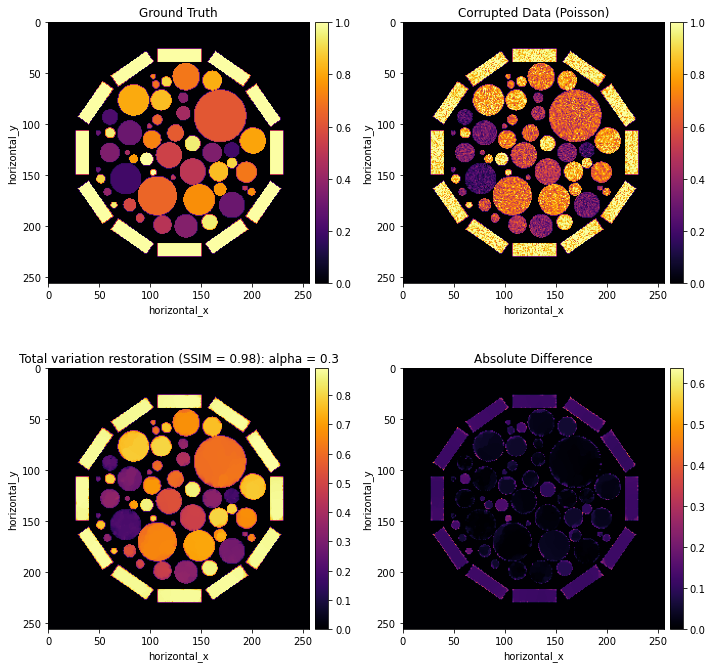

In [7]:
show2D([data, noisy_data, pdhg.solution, (pdhg.solution-data).abs()],
          title=["Ground Truth", 
                  "Corrupted Data (Poisson)", 
                  "Total variation restoration (SSIM = {:.2f}): alpha = {}".format(val_ssim_tv, alpha),
                  "Absolute Difference"],
         origin = "upper", cmap="inferno", size=(10,10))